# Predicting Pet Insurance Claims - Pre-processing and Modeling
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* Split data into Train and Test sets
* Complete any remaining feature engineering
* Pre-process the data to prepare for modeling
* Create and assess initial models

## 2 Setup
### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.pipeline import make_pipeline

# from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, make_scorer
# from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import __version__ as sklearn_version

import datetime
import os
import pickle
from library.sb_utils import save_file

### 2.2 Data Load and Preview
At the end of exploratory data analysis, we had an updated data file for our pets data containing all pet records. As a quick review, here's a summary:
* Shape - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* Basic Info - For each pet, we have some basic info including species, breed, and age at time of enrollment.
* YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
* Policy Info - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* Claims Data - We also have claims data for each pet covering the first two policy years including:
* Number of claims per year and total (years 1 and 2 combined)
* Average claim amount per year and total (years 1 and 2 combined)
* Amount of claims per year and total (years 1 and 2 combined)

Let's load in the data and preview.

In [2]:
pets = pd.read_csv('../data/pets.csv', index_col=0)
pets.head(8).T

,0,1,2,3,4,5,6,7
PetId,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair,Boxer
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4,75.14
Deductible,200,500,500,500,700,700,250,700
AgeYr1,3,0,0,0,0,2,0,5
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0,2873.47
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38,2497.03
AvgClaimsYr1,0.0,0.0,213.543333,0.0,801.361111,296.185556,0.0,410.495714


### 2.3 Initial Plan for Pre-processing and Feature Engineering
Our primary goal for pre-processing will be to prepare our data for modeling. At a our minimum, this will include scaling and/or normalizing our features against one another, generating any required dummy values for categorical columns and splitting our data into our train and test sets.

**Train / Test Prep**
* Drop all 'Yr2' and 'Total' columns except AmtClaimsYr2 (our target) as this is data we would not have available for making predictions
* Split our data into training and test sets

**Feature Engineering** 
* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed - Employ a method to reduce the number of unique values
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)
* AmtClaimsYr1 and AvgClaimsYr1 - consider rolling these up into one feature or rolling these up by breed
* NumClaimsYr1 - Consider dropping this column or rolling up by breed; Could also be converted to binary (claims and no-claims)

**Pre-processing**
* Species - Convert to binary
* Breed - Create dummy variables for the remaining breeds
* All columns - Scale or normalize any columns not already converted to binary or dummy variables


## 3 Split the Data
As a first step, we'll take care of the train/test split to prevent any data leakage. Before we split the data, we need to drop some of the features that won't be part of our model. 

In addition, we observed in data wrangling and EDA, that there are a wide variety of breeds in our data. If we want to maintain a balanced distribution of breeds after our split, we'll need to use *stratify* to achieve this. Stratify won't work with our current data since we have some breeds with only 1 pet and stratify requires a minimum of 2 in each category.

To work around this, we can take a few steps to reduce the number of unique values for 'Breed'. In doing so, we can ensure a minimum number of pets in each category. 

### 3.1 Drop Unnecessary or Unusable Features 
Before we move on with preprocessing, we need to drop some features from the data that are either unnecessary or unusable in our predictive model. These include:
* **Year 2 Claims Data** - Using year 2 claims data to predict year 2 claims amount would be unfair and introduce data leakage into our model. The result would be that we would end up with a model that is overfit to our current dataset and would likely not generalize well with new data.
* **Premium and Deductible** - Premium and deductible amounts are set by the insurance company and are not directly related to the number or amount of claims for any specific pet.
* **PetId** - An arbitrary ID number that is meaningless when predicting insurance claims amounts.

In [3]:
# Drop features that won't be part of the model
drop_cols = ['PetId', 'Premium', 'Deductible', 'AvgClaimsYr2', 'NumClaimsYr2', 'AmtClaimsTotal', 'AvgClaimsTotal',
             'NumClaimsTotal', 'YrsWithClaims']
pets.drop(columns=drop_cols, inplace=True)

### 3.2 Reduce the Number of Unique Breeds
To reduce the number of unique breeds in the data, we'll follow the steps below:

1. Set threshold and save a list of breeds with counts greater or equal to the threshold
2. Write a function to update the breed for a row based on whether or not it exists in the list from step 1
3. Create a copy of our original df and apply the function
4. Print out the before and after numbers for our count of unique breeds

As part of step 2 above, we'll update the breed name for breeds with a low pet count to group them together in an *Other* category. To ensure we don't lose any species-specific information, we'll create two versions of *Other*, 'Other Cat' and 'Other Dog'. 

In [4]:
breeds = pd.read_csv('../data/breeds.csv', index_col=0)
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,Abyssinian,Affenpinscher,Afghan Hound,Aidi,Airedale Terrier,Akbash Dog,Akita,Alaskan Klee Kai,Alaskan Malamute,American Bandogge Mastiff
Species,Cat,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
PetCount,24,3,10,2,41,1,49,30,64,1
AvgTotalClaims,1462.780417,1746.19,645.543,0.0,1338.705366,11383.6,1217.91102,1510.666333,3096.346719,2295.07
AvgNumClaims,4.25,1.333333,2.5,0.0,2.097561,23.0,3.591837,3.166667,3.765625,8.0
WeightedTotalClaims,35106.73,5238.57,6455.43,0.0,54886.92,11383.6,59677.64,45319.99,198166.19,2295.07
WeightedNumClaims,102.0,4.0,25.0,0.0,86.0,23.0,176.0,95.0,241.0,8.0


In [5]:
# Set threshold
threshold = 100

# Preserve list of Breeds with count greater equal to the threshold
breeds_list = breeds[breeds.PetCount >= threshold].Breed.tolist()

# Create function to update breed column based on threshold
def update_breed(row):
    if (row["Breed"] in breeds_list):
        return row["Breed"]
    else:
        if (row["Species"] == 'Cat'):
            return 'Other Cat'
        else:
            return 'Other Dog'

# Print number of unique breeds before update
print("Number of unique breeds before: " + str(pets.Breed.nunique()))

# Apply function to update Breed
pets["Breed"] = pets.apply(update_breed, axis=1)
print("Number of unique breeds after: " + str(pets.Breed.nunique()))

Number of unique breeds before: 373
Number of unique breeds after: 79


### 3.3 Split Data into Train and Test

In [6]:
# Split out target and features
y = pets["AmtClaimsYr2"].values
X = pets.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=pets['Breed'])

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 7)
(10000, 7)
(40000,)
(10000,)


## 4 Feature Engineering
Now that we've split the data into train and test sets, we can proceed with feature engineering without worrying about data leakage. As a next step, let's replace our **breeds** dataframe (which was based on the entire dataset) with an updated version based on our training dataset. Then we can pull in some of the summary statistics as new features.

* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Add features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping, etc.)

### 4.1 Breed Statistics
After we create our new dataframe grouped by breed, we'll write a function to pull the summary statistics into our training data. 

In [8]:
# Group pets by breed and aggregate data
breeds = X_train.groupby(by=['Breed', 'Species']).agg({'Breed': ['count'],
                                                       'AmtClaimsYr1': ['mean'],
                                                       'NumClaimsYr1': ['mean'],
                                                       'AvgClaimsYr1': ['mean']}).reset_index()
breeds.columns = ['Breed', 'Species', 'PetCount', 'BreedAvgTotalClaims', 'BreedAvgNumClaims',
                  'BreedAvgClaimAmt']
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,American Pitbull Terrier,American Shorthair,American Staffordshire Terrier,Aussiedoodle,Australian Labradoodle,Australian Shepherd,Beagle,Bengal,Bernedoodle,Bernese Mountain Dog
Species,Dog,Cat,Dog,Dog,Dog,Dog,Dog,Cat,Dog,Dog
PetCount,270,322,86,83,502,380,199,117,232,255
BreedAvgTotalClaims,1474.993852,384.981832,1050.282209,310.633012,593.959462,592.635763,758.266834,854.694786,850.40694,1531.275804
BreedAvgNumClaims,2.3,0.776398,1.872093,1.144578,1.904382,1.1,1.849246,1.188034,2.465517,2.694118
BreedAvgClaimAmt,423.326961,152.345708,275.456691,106.56157,162.506365,212.536037,210.407993,205.824534,230.569472,315.789746


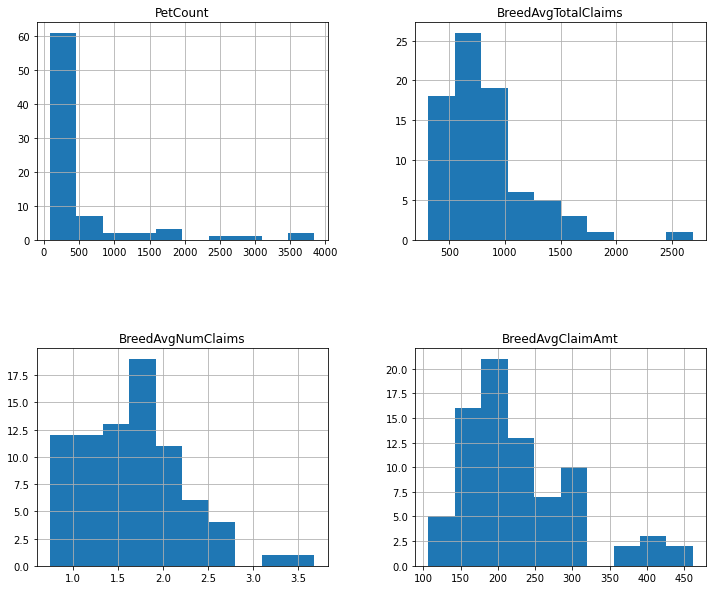

In [9]:
# Preview the distributions of each of our numeric features
breeds.hist(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

# TODO - Add Summary
* All distributions are right-tailed
* What implications does this have for our predictions?

In [10]:
# Create function to pull breed statistics into pets dataframe
def add_breed_stats(df):
    features = ['Breed', 'BreedAvgTotalClaims', 'BreedAvgNumClaims', 'BreedAvgClaimAmt']
    breed_stats = breeds.copy()[features]
    df = pd.merge(df, breed_stats, how='left', on='Breed')
    return df

In [11]:
# Apply function to training and test data & preview result
X_train = add_breed_stats(X_train)
X_test = add_breed_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Cat,Cat,Cat,Dog,Dog,Dog,Dog
Breed,Labrador Retriever,Domestic Shorthair,Domestic Shorthair,Domestic Shorthair,Labradoodle,Golden Retriever,Golden Retriever,Other Dog
AgeYr1,0,8,0,0,1,0,1,0
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,2420.36,0.0,415.79,0.0,2030.23,0.0
AvgClaimsYr1,0.0,0.0,605.09,0.0,103.9475,0.0,156.171538,0.0
NumClaimsYr1,0,0,4,0,4,0,13,0
BreedAvgTotalClaims,1051.183855,388.096832,388.096832,388.096832,573.550654,929.597605,929.597605,937.093707
BreedAvgNumClaims,2.084123,0.811677,0.811677,0.811677,1.667431,2.103086,2.103086,1.89334
BreedAvgClaimAmt,271.553273,137.392321,137.392321,137.392321,167.451173,241.834159,241.834159,256.990491


In [12]:
# Check for null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              40000 non-null  object 
 1   Breed                40000 non-null  object 
 2   AgeYr1               40000 non-null  int64  
 3   YoungAge             40000 non-null  int64  
 4   AmtClaimsYr1         40000 non-null  float64
 5   AvgClaimsYr1         40000 non-null  float64
 6   NumClaimsYr1         40000 non-null  int64  
 7   BreedAvgTotalClaims  40000 non-null  float64
 8   BreedAvgNumClaims    40000 non-null  float64
 9   BreedAvgClaimAmt     40000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 3.4+ MB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              10000 non-null  object 
 1   Breed                10000 non-null  object 
 2   AgeYr1               10000 non-null  int64  
 3   YoungAge             10000 non-null  int64  
 4   AmtClaimsYr1         10000 non-null  float64
 5   AvgClaimsYr1         10000 non-null  float64
 6   NumClaimsYr1         10000 non-null  int64  
 7   BreedAvgTotalClaims  10000 non-null  float64
 8   BreedAvgNumClaims    10000 non-null  float64
 9   BreedAvgClaimAmt     10000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 859.4+ KB


So after pulling in our breed stats, we can see that we don't have any missing values in our data. Next, let's move on to look at Pet Age statistics.

### 4.2 Pet Age
Similar to breed, we would expect a wide range of vairiability in our claims data on a per-pet basis at each age level. However, averaging the claims data per age could help to offset some of that variability we see for individual pets. 

We'll start by grouping our data based on pet age and species.

In [14]:
# Group pets by age at enrollment and aggregate data
pets_by_age = X_train.groupby(by=["AgeYr1", "Species"]).agg({'AgeYr1': ['count'],
                                                             'AmtClaimsYr1': ['mean'],
                                                             'NumClaimsYr1': ['mean'],
                                                             'AvgClaimsYr1': ['mean']}).reset_index()
pets_by_age.columns = ['AgeYr1', 'Species', 'PetCount', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims',
                       'AgeYr1AvgClaimAmt']
pets_by_age.head(10).T

,0,1,2,3,4,5,6,7,8,9
AgeYr1,0,0,1,1,2,2,3,3,4,4
Species,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog
PetCount,3156,22236,724,3010,576,2112,399,1413,330,1141
AgeYr1AvgTotalClaims,432.488032,907.422743,427.693287,690.817934,285.635694,632.375445,226.388346,703.35913,527.915758,718.571534
AgeYr1AvgNumClaims,0.973701,2.004362,0.737569,1.354153,0.550347,1.207386,0.488722,1.282378,0.960606,1.213848
AgeYr1AvgClaimAmt,139.760719,235.77412,168.600161,212.989241,117.99364,202.839673,103.883991,220.712716,188.169402,212.752902


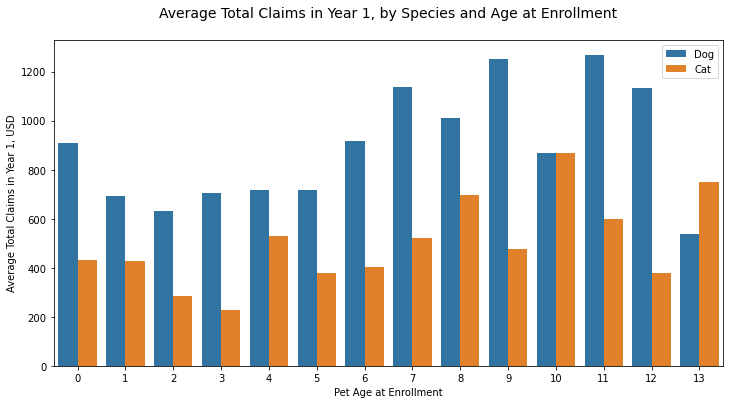

In [15]:
# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x="AgeYr1", y="AgeYr1AvgTotalClaims", hue="Species", data=pets_by_age, hue_order=['Dog', 'Cat'] 
           ).set(xlabel="Pet Age at Enrollment", ylabel="Average Total Claims in Year 1, USD")

# Plot the legend and display
plt.title("Average Total Claims in Year 1, by Species and Age at Enrollment", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

As noted in EDA, dogs pretty consistently have higher average total claims than cats at just about every age level with the exception of a couple of ages at the high end of our range. 

There is a bit more variability in the trends for each species across the age range. We see that as age increases, the average claims amount tends to rise, but it's not a clear linear relationship. In any case, incorporating these averages should help our predictive model by adding some population-level features into the mix.  

In [16]:
# Create function to pull age statistics into pets dataframe
def add_age_stats(df):
    features = ['AgeYr1', 'Species', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims', 'AgeYr1AvgClaimAmt']
    age_stats = pets_by_age.copy()[features]
    df = pd.merge(df, age_stats, how='left', on=(['AgeYr1', 'Species']))
    return df

In [17]:
# Apply function to training and test data & preview result
X_train = add_age_stats(X_train)
X_test = add_age_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Cat,Cat,Cat,Dog,Dog,Dog,Dog
Breed,Labrador Retriever,Domestic Shorthair,Domestic Shorthair,Domestic Shorthair,Labradoodle,Golden Retriever,Golden Retriever,Other Dog
AgeYr1,0,8,0,0,1,0,1,0
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,2420.36,0.0,415.79,0.0,2030.23,0.0
AvgClaimsYr1,0.0,0.0,605.09,0.0,103.9475,0.0,156.171538,0.0
NumClaimsYr1,0,0,4,0,4,0,13,0
BreedAvgTotalClaims,1051.183855,388.096832,388.096832,388.096832,573.550654,929.597605,929.597605,937.093707
BreedAvgNumClaims,2.084123,0.811677,0.811677,0.811677,1.667431,2.103086,2.103086,1.89334
BreedAvgClaimAmt,271.553273,137.392321,137.392321,137.392321,167.451173,241.834159,241.834159,256.990491


## 5. Data Preprocessing

Now that we've engineered a couple of new features, let's take a look at our data and complete any additional pre-processing on categorical features before we move on to model creation. 

Let's review the dtypes in our dataset.

In [18]:
print(X_train.dtypes.value_counts())
obj_cols = X_train.select_dtypes(include=['object']).columns.to_list()
print("Remaining categorical columns: " + str(obj_cols))

float64    8
int64      3
object     2
dtype: int64
Remaining categorical columns: ['Species', 'Breed']


We still have two object columns to deal with before we can move on to modeling - Species and Breed. As observed earlier, species contains two possible values - Cat and Dog, while breed contains 79 unique values (after some manipulation). 

We can create a preprocessor to use OneHotEncoder as part of our pipeline. We can use the (drop='if_binary') argument to utilize OneHotEncoder on both columns even though one is binary and the other has 79 possible values.

In [19]:
# Create list of categorical and numerical columns
categorical_columns = ['Species', 'Breed']
numerical_columns = ['AgeYr1', 'YoungAge', 'AmtClaimsYr1',
       'AvgClaimsYr1', 'NumClaimsYr1', 'BreedAvgTotalClaims',
       'BreedAvgNumClaims', 'BreedAvgClaimAmt', 'AgeYr1AvgTotalClaims_x',
       'AgeYr1AvgNumClaims_x', 'AgeYr1AvgClaimAmt_x', 'AgeYr1AvgTotalClaims_y',
       'AgeYr1AvgNumClaims_y', 'AgeYr1AvgClaimAmt_y']

# Create a preprocessor to encode the categorical columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    remainder='passthrough'
)

## 6 Baseline Models
Next we'll make a pipeline including the preprocessor we created above as one of the pipeline steps. For our baseline model review, let's start by looking at a dummy regressor using the mean of our data. Then we can compare the performance with a simple linear regression model. This should provide us with a good starting point to build on with more sophisticated modeling techniques.

In terms of scoring, we'll look at **mean absolute error** since this will render scores in the units of our target variable (i.e., USD). This will simplifiy model comparison by making the results more intuitive.

To begin, we'll make the pipeline including the following steps:
* preprocessor - created above to replace our categorical variables
* regressor - to allow for passing in different regressor functions

We will also create a scorer to calculate the mean absolute error for our cross validation result.

In [24]:
# Create scoring function
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### 6.1 Dummy Regressor

In [25]:
# Dummy regressor
regressor = DummyRegressor(strategy = 'mean')

# Make pipeline and get results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
round(np.mean(cv_results['test_score']), 2)

-1006.36

Looking at the results of the dummy regressor, we see that just using the mean value for our target leaves us with an mae of over 1000 which in this case, would translate to about \$1000. Let's see if we can improve upon that by using a simple linear regression model.

### 6.2 Simple Linear Regression Model

In [26]:
# Linear regression
regressor = LinearRegression()

# Make pipeline and get results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
round(np.mean(cv_results['test_score']), 2)

-915.65

# TODO - Update based on new result, or better yet implement random_state
Nice... by simply utilizing a basic linear regression model with no tuning, we've already improved upon simply using the mean value for our predictions. The mae is still relatively high at over 934, but if we were to stop here, this would translate to an improvement of over \$90, or roughly 9% better than baseline.

As a next step, let's see if we can improve on our results by adding feature selection to our model. To do this, we'll use the 'SelectKBest' method to help us determine the best number of features for our model. 

### 6.3 Linear Regression with Feature Selection

In [27]:
# Select K best features (default)
select_k_best = SelectKBest(f_regression, k=10)

# Make pipeline and get results
pipe = make_pipeline(preprocessor, select_k_best, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
round(np.mean(cv_results['test_score']), 2)

-914.89

As seen above, using the default value for k (i.e., 10) shows only a tiny improvement over our linear regression model without feature selection. Given that our data includes 91 features, it's possible 10 is not the best value for k though. As a next step, let's cycle through a few different possible k values and then plot the results to see how the scores change with each value of k.

#### 6.3.1 Evaluate k Values

In [36]:
# Create a list of potential k values to start
k = [1, 5, 10, 15, 20, 25]

# Create grid parameters for our grid search
grid_params = {'selectkbest__k': k}

# Create our grid search model
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, scoring=mae_scorer, cv=5, n_jobs=-1)

# Fit the training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species',
                                                                          'Breed'])])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f10c81640d0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 5, 10, 15, 20, 25]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [37]:
# Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 10}

In [38]:
# Get cv_score mean, std and k value
score_mean = [mean for mean in lr_grid_cv.cv_results_['mean_test_score']]
score_std = [std for std in lr_grid_cv.cv_results_['std_test_score']]
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

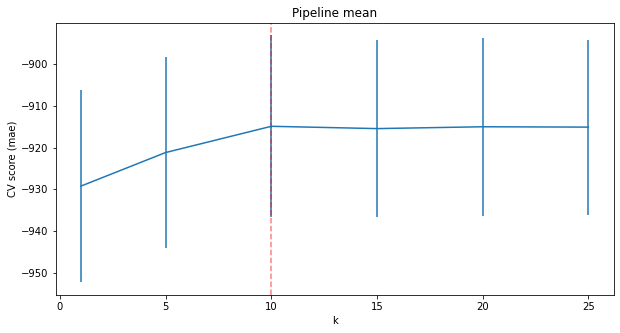

In [39]:
# Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std) 
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (mae)')
plt.title('Pipeline mean');

# ToDo Add observations about the best k
* Also, why look further?

In [41]:
# Create a list of potential k values to start
k = [6, 7, 8, 9, 10]

# Create grid parameters for our grid search
grid_params = {'selectkbest__k': k}

# Create our grid search model
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, scoring=mae_scorer, cv=5, n_jobs=-1)

# Fit the training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species',
                                                                          'Breed'])])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f10c81640d0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [6, 7, 8, 9, 10]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [42]:
# Get score mean and std for each k
score_mean = [mean for mean in lr_grid_cv.cv_results_['mean_test_score']]
score_std = [std for std in lr_grid_cv.cv_results_['std_test_score']]
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [43]:
# Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 9}

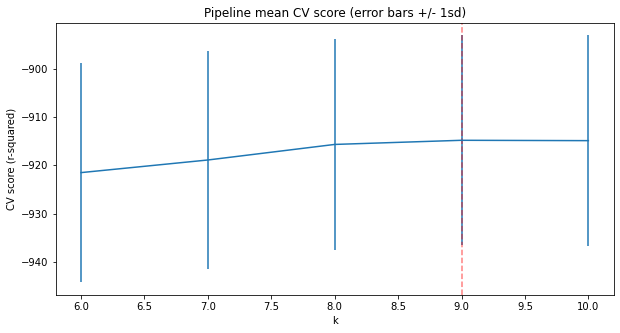

In [44]:
# Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [45]:
# Get the selected features using the best estimator
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

# Get the coefs for the selected features
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_

# Get the list of feature names after transformation
trans_feats = list(lr_grid_cv.best_estimator_.named_steps.columntransformer.\
                           transformers_[0][1].get_feature_names())
orig_feats = ['AgeYr1', 'YoungAge', 'AmtClaimsYr1', 'AvgClaimsYr1', 'NumClaimsYr1', 'BreedAvgTotalClaims',
              'BreedAvgNumClaims', 'BreedAvgClaimAmt', 'AgeYr1AvgTotalClaims','AgeYr1AvgNumClaims',
              'AgeYr1AvgClaimAmt']

# Print the list of the features in order of importance
features = np.array(trans_feats + orig_feats)
selected_features = features[selected]
pd.Series(coefs, index=selected_features).sort_values(ascending=False)

NumClaimsYr1            110.200307
AgeYr1                   68.314305
BreedAvgClaimAmt          1.112014
BreedAvgTotalClaims       0.307271
AgeYr1AvgClaimAmt         0.244503
AmtClaimsYr1              0.122355
AgeYr1AvgTotalClaims      0.020985
AvgClaimsYr1             -0.055095
BreedAvgNumClaims       -35.790661
dtype: float64

# START here with observations on the above

In [ ]:
# y_pred = model.predict(X_train)

# mae = median_absolute_error(y_train, y_pred)
# y_pred = model.predict(X_test)
# mae = median_absolute_error(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(5, 5))
# plt.scatter(y_test, y_pred)
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
# plt.title('Ridge model, small regularization')
# plt.ylabel('Model predictions')
# plt.xlabel('Truths')
# plt.xlim([0, 1500])
# _ = plt.ylim([0, 1500])

### 6.1 Create the Baseline Model

## 7 Model Tuning
To start the tuning process, let's create a simple pipeline and then we can refine it further as we go. For this initial pipeline, we'll use the standard scaler with a linear regression model as above, but we'll add the 'SelectKBest' feature selection method starting with the default value of 10. This will create a model using only the 10 best features from our data rather than all 93.

### 7.1 Simple Pipeline

### 7.2 Grid Search
As noted above, our initial pipeline only uses the default value for k (10). As a next step in our model evaluation, let's check our performance across a range of k values. 

The most important feature in our data appears to be the number of claims in year 1 followed closely by the amount of claims in year 1. This matches up with what we observed during EDA, where these two features were most closely correlated with our target. Beyond these two, pet age also scores high in terms of importance followed by a number of features that are rollups of breed and age related statistics. Surprisingly, the importance of species appears to be lower than expected.

Next, let's create a random forest model and see how it performs in comparison to our linear regression model.

### 7.3 Random Forest Regressor
We'll start with a basic random forest model as a baseline and then move on to do some hyperparameter tuning.

In [ ]:
# Define a Random Forest Pipeline
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [ ]:
# Estimate the pipeline's performance.
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [ ]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

In [ ]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

It looks like our baseline random forest model has actually performed worse than our linear regression model. That's not too surprising cconsidering we've done nothing to tune the available parameters. As a next step, let's incorporate a random grid search across a range of hyperparameters to see if we can improve our results.

We'll start by building a grid for our random search. Then we'll complete the random search across this grid using cross validation to see if we can arrive at a better set of hyperparameters. Finally, we'll compare the best parameters with our random forest baseline to see what kind of improvement we get.

### 7.4 Random Forest Hyperparameter Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Print the grid
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# Create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
# View best performing parameter combination
rf_random.best_params_

In [ ]:
# Establish base model for comparison
baseline_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
print("r2_score (baseline): {:.2f}".format(r2_score(y_test, baseline_predictions)))
print("mean absolute error (baseline): {:.2f} \n".format(mean_absolute_error(y_test, baseline_predictions)))

# Compare with best model from random search
best_random_model = rf_random.best_estimator_
best_random_model.fit(X_train, y_train)
best_random_predictions = best_random_model.predict(X_test)
print("r2_score (best random): {:.2f}".format(r2_score(y_test, best_random_predictions)))
print("mean absolute error (best random): {:.2f} \n".format(mean_absolute_error(y_test, best_random_predictions)))

So even using the best random forest model, our performance is still looking slightly worse than with our linear model when looking at only the best k features. 

# TODO - Where to go from here??

### 7.5 


## 8 Save Model

In [ ]:
# # Store some basic information about the model
# best_model = rf_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

In [ ]:
# # save the model

# modelpath = '../models'
# save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

## 8 Summary

TBD

### 4.2 Premium and Deductible
Now that we have the Premium and Deductible rolled up to a breed-level statistic, we should be able to safely drop the pet-level columns. The rationale for this is that customers can select either a premium or a deductible and once one is selected, the other is set automatically. 

This leads to a couple of conclusions:
* At a pet-level, we expect to see a wide range of premiums and deductibles for a single breed (due to customer choice)
* When we average these values out at a breed level, we should see some patterns emerging that might be indicative of the *assumed risk level* for each breed.

Let's take a look.

In [ ]:
# Create a scatterplot showing spread vs. average total claims
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="BreedAvgPremium", x="BreedAvgDeductible", data=breeds, hue="Species", 
                size="PetCount", sizes=(20, 200), alpha=0.5)\
                .set(title="", ylabel="Average Premium, USD",
                     xlabel="Average Deductible, USD")

# Add title and display plot
plt.title("Average Premium vs. Average Deductible, per Breed", y=1.05, fontsize=14)
# plt.suptitle("(TBD)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='lower right')
plt.show()

The plot above shows a couple of interesting insights.

1. Premiums and deductibles are consistently lower for cats
2. As the average deductible amount goes up for cat breeds, the average premium amount stays roughly the same
3. As the average deductible amount goes up for dog breeds, the average premium amount goes up at a fairly steady linear rate

**So the overall takeaways:**
* Cats seem to be considered lower risk than dogs
* For dog breeds, the premium and deductible amounts vary and could indicate that some breeds are considered riskier to insure than others

Let's drop the pet-level premium and deductible features before moving on.